# Making Multiple Markets

## Overview

By diversifying your assets and constructing a market-making book, you can achieve improved risk-adjusted returns through the effects of diversification. In this example, we will demonstrate how the statistics of your market-making portfolio change as you increase the number of assets for which you create markets.

To implement Grid Trading using the GLFT market-making model across multiple assets universally without needing to adjust parameters, a few modifications are required:

Order quantities vary between assets due to differences in price, trading volume, and liquidity in the order book. To backtest all at once, you need to normalize your order quantities and make adjustments accordingly.

In certain assets, market trades primarily take place at the best bid and offer levels. Since we only calculate our trading intensity when market trades match our quotes, you may not achieve adequate trading intensity to suit your trading intensity function in such cases. As a result, you'll need to explore alternative methods to determine your half spread and skew based on order arrival depths or you need to increase your reaction interval to get more deeper order arrival depth but it leads you to react delayed especially in a fast-moving market.

See how $ adj_2 $ is determined to normalize different order quantities.

<div class="alert alert-success">
This example is for educational purposes only and demonstrates effective strategies for high-frequency market-making schemes. All backtests are based on a 0.005% rebate, the highest market maker rebate available on Binance Futures. See <a href="https://www.binance.com/en/support/announcement/binance-upgrades-usd%E2%93%A2-margined-futures-liquidity-provider-program-2023-04-04-01007356e6514df3811b0c80ab8c83bf">Binance Upgrades USDⓢ-Margined Futures Liquidity Provider Program</a> for more details.
</div>

In [1]:
from numba import njit
from numba.typed import Dict

from hftbacktest import BUY, SELL
from hftbacktest import HftBacktest, Linear, FeedLatency, SquareProbQueueModel, Stat, GTX

import numpy as np

@njit(cache=True)
def measure_trading_intensity(order_arrival_depth, out):
    max_tick = 0
    for depth in order_arrival_depth:
        if not np.isfinite(depth):
            continue
        
        # Sets the tick index to 0 for the nearest possible best price 
        # as the order arrival depth in ticks is measured from the mid-price
        tick = round(depth / .5) - 1
        
        # In a fast-moving market, buy trades can occur below the mid-price (and vice versa for sell trades) 
        # since the mid-price is measured in a previous time-step; 
        # however, to simplify the problem, we will exclude those cases.
        if tick < 0 or tick >= len(out):
            continue
        
        # All of our possible quotes within the order arrival depth, 
        # excluding those at the same price, are considered executed.
        out[:tick] += 1
        
        max_tick = max(max_tick, tick)
    return out[:max_tick]


@njit(cache=True)
def compute_coeff(xi, gamma, delta, A, k):
    inv_k = np.divide(1, k)
    c1 = 1 / (xi * delta) * np.log(1 + xi * delta * inv_k)
    c2 = np.sqrt(np.divide(gamma, 2 * A * delta * k) * ((1 + xi * delta * inv_k) ** (k / (xi * delta) + 1)))
    return c1, c2


@njit(cache=True)
def linear_regression(x, y):
    sx = np.sum(x)
    sy = np.sum(y)
    sx2 = np.sum(x ** 2)
    sxy = np.sum(x * y)
    w = len(x)
    slope = (w * sxy - sx * sy) / (w * sx2 - sx**2)
    intercept = (sy - slope * sx) / w
    return slope, intercept


@njit(cache=True)
def gridtrading_glft_mm(hbt, stat, order_qty):
    arrival_depth = np.full(20_000_000, np.nan, np.float64)
    mid_price_chg = np.full(20_000_000, np.nan, np.float64)

    t = 0
    prev_mid_price_tick = np.nan
    mid_price_tick = np.nan
    
    tmp = np.zeros(500, np.float64)
    ticks = np.arange(len(tmp)) + .5
    
    A = np.nan
    k = np.nan
    volatility = np.nan
    gamma = 0.05
    delta = 1
    adj1 = 1
    
    # adj2 is determined according to the order quantity.
    grid_num = 20
    max_position = grid_num * order_qty
    adj2 = 1 / max_position
    
    # Checks every 100 milliseconds.
    while hbt.elapse(100_000):
        #--------------------------------------------------------
        # Records market order's arrival depth from the mid-price.
        if not np.isnan(mid_price_tick):
            depth = -np.inf
            for trade in hbt.last_trades:
                side = trade[3]
                trade_price_tick = trade[4] / hbt.tick_size
                
                if side == BUY:
                    depth = np.nanmax([trade_price_tick - mid_price_tick, depth])
                else:
                    depth = np.nanmax([mid_price_tick - trade_price_tick, depth])
            arrival_depth[t] = depth
        
        hbt.clear_last_trades()
        
        prev_mid_price_tick = mid_price_tick
        mid_price_tick = (hbt.best_bid_tick + hbt.best_ask_tick) / 2.0
        
        # Records the mid-price change for volatility calculation.
        mid_price_chg[t] = mid_price_tick - prev_mid_price_tick
        
        #--------------------------------------------------------
        # Calibrates A, k and calculates the market volatility.
        
        # Updates A, k, and the volatility every 5-sec.
        if t % 50 == 0:
            # Window size is 10-minute.
            if t >= 6_000 - 1:
                # Calibrates A, k
                tmp[:] = 0
                lambda_ = measure_trading_intensity(arrival_depth[t + 1 - 6_000:t + 1], tmp)
                # To properly calibrate A and K, a sufficient number of data points is required, here, with a minimum of three.
                # If market trades only take place at the best bid and offer, an alternative method may be necessary 
                # to compute half spread and skew, since fitting a function might not be feasible  due to insufficient 
                # data points.
                # Alternatively, you can increase the time-step for measuring order arrivals,  
                # but this could result in a delayed response.
                half_spread_one = False
                if len(lambda_) > 2:
                    lambda_ = lambda_[:70] / 600
                    x = ticks[:len(lambda_)]
                    y = np.log(lambda_)
                    k_, logA = linear_regression(x, y)
                    A = np.exp(logA)
                    k = -k_
           
                # Updates the volatility.
                volatility = np.nanstd(mid_price_chg[t + 1 - 6_000:t + 1]) * np.sqrt(10)
    
        #--------------------------------------------------------
        # Computes bid price and ask price.
    
        c1, c2 = compute_coeff(gamma, gamma, delta, A, k)
        
        half_spread = max((c1 + 1 / 2 * c2 * volatility) * adj1, 0.5)
        skew = max(c2 * volatility * adj2, 0.5 * adj2)
        
        bid_depth = half_spread + skew * hbt.position
        ask_depth = half_spread - skew * hbt.position
    
        # If the depth is invalid, set a large spread to prevent execution.
        if not np.isfinite(bid_depth):
            bid_depth = 1_000
        if not np.isfinite(ask_depth):
            ask_depth = 1_000

        bid_price = min(round(mid_price_tick - bid_depth), hbt.best_bid_tick) * hbt.tick_size
        ask_price = max(round(mid_price_tick + ask_depth), hbt.best_ask_tick) * hbt.tick_size
        
        order_interval = max(round(half_spread) * hbt.tick_size, hbt.tick_size)
        bid_price = np.floor(bid_price / order_interval) * order_interval
        ask_price = np.ceil(ask_price / order_interval) * order_interval
        
        #--------------------------------------------------------
        # Updates quotes.
        
        hbt.clear_inactive_orders()
        
        # Creates a new grid for buy orders.
        new_bid_orders = Dict.empty(np.int64, np.float64)
        if hbt.position < max_position:
            for i in range(grid_num):
                bid_price -= i * order_interval
                bid_price_tick = round(bid_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_bid_orders[bid_price_tick] = bid_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == BUY and order.cancellable and order.order_id not in new_bid_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_bid_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_buy_order(order_id, order_price, order_qty, GTX)
        
        # Creates a new grid for sell orders.
        new_ask_orders = Dict.empty(np.int64, np.float64)
        if hbt.position > -max_position:
            for i in range(grid_num):
                ask_price += i * order_interval
                ask_price_tick = round(ask_price / hbt.tick_size)
                
                # order price in tick is used as order id.
                new_ask_orders[ask_price_tick] = ask_price
        for order in hbt.orders.values():
            # Cancels if an order is not in the new grid.
            if order.side == SELL and order.cancellable and order.order_id not in new_ask_orders:
                hbt.cancel(order.order_id)
        for order_id, order_price in new_ask_orders.items():
            # Posts an order if it doesn't exist.
            if order_id not in hbt.orders:
                hbt.submit_sell_order(order_id, order_price, order_qty, GTX)
        
        t += 1
        
        if t >= len(arrival_depth) or t >= len(mid_price_chg):
            raise Exception
        
        # Records the current state for stat calculation.
        stat.record(hbt)

The order quantity is determined to be equivalent to a notional value of $1000.

In [2]:
from hftbacktest import COL_SIDE, COL_PRICE

def backtest(args):
    asset_name, asset_info = args

    hbt = HftBacktest(
        ['data/{}_{}.npz'.format(asset_name, date) for date in range(20230401, 20230420)],
        tick_size=asset_info['tick_size'],
        lot_size=asset_info['lot_size'],
        maker_fee=-0.00005,
        taker_fee=0.0007,
        order_latency=FeedLatency(1),
        queue_model=SquareProbQueueModel(),
        asset_type=Linear,
        snapshot='data/{}_20230331_eod.npz'.format(asset_name),
        trade_list_size=10000,
    )

    stat = Stat(hbt)

    # Obtains the mid-price of the assset to determine the order quantity.
    data = np.load('data/{}_20230331_eod.npz'.format(asset_name))['data']
    best_bid = max(data[data[:, COL_SIDE] == 1][:, COL_PRICE])
    best_ask = min(data[data[:, COL_SIDE] == -1][:, COL_PRICE])
    mid = (best_bid + best_ask) / 2.0

    # Sets the order quantity to be equivalent to a notional value of $1000.
    order_qty = max(round((1000 / mid) / asset_info['lot_size']), 1) * asset_info['lot_size']

    gridtrading_glft_mm(hbt, stat.recorder, order_qty)

    np.savez(
        '{}_stat'.format(asset_name),
        timestamp=np.asarray(stat.timestamp),
        mid=np.asarray(stat.mid),
        balance=np.asarray(stat.balance),
        position=np.asarray(stat.position),
        fee=np.asarray(stat.fee),
    )

By utilizing multiprocessing, backtesting of multiple assets can be conducted simultaneously.

In [3]:
%%capture
import json

from multiprocessing import Pool

with open('assets.json', 'r') as f:
    assets = json.load(f)

with Pool(32) as p:
    print(p.map(backtest, list(assets.items())))

In [4]:
import pandas as pd

equity_values = {}
for asset_name in assets.keys():
    stat = np.load('{}_stat.npz'.format(asset_name))
    timestamp = stat['timestamp']
    mid = stat['mid']
    balance = stat['balance']
    position = stat['position']
    fee = stat['fee']
    
    equity = mid * position + balance - fee
    equity = pd.Series(equity, index=pd.to_datetime(timestamp, unit='us', utc=True))
    equity_values[asset_name] = equity.resample('5min').last()

You can see the equity curve of individual assets and notice how combining multiple assets can lead to a smoother equity curve, thereby enhancing risk-adjusted returns.

Text(0, 0.5, 'Equity ($)')

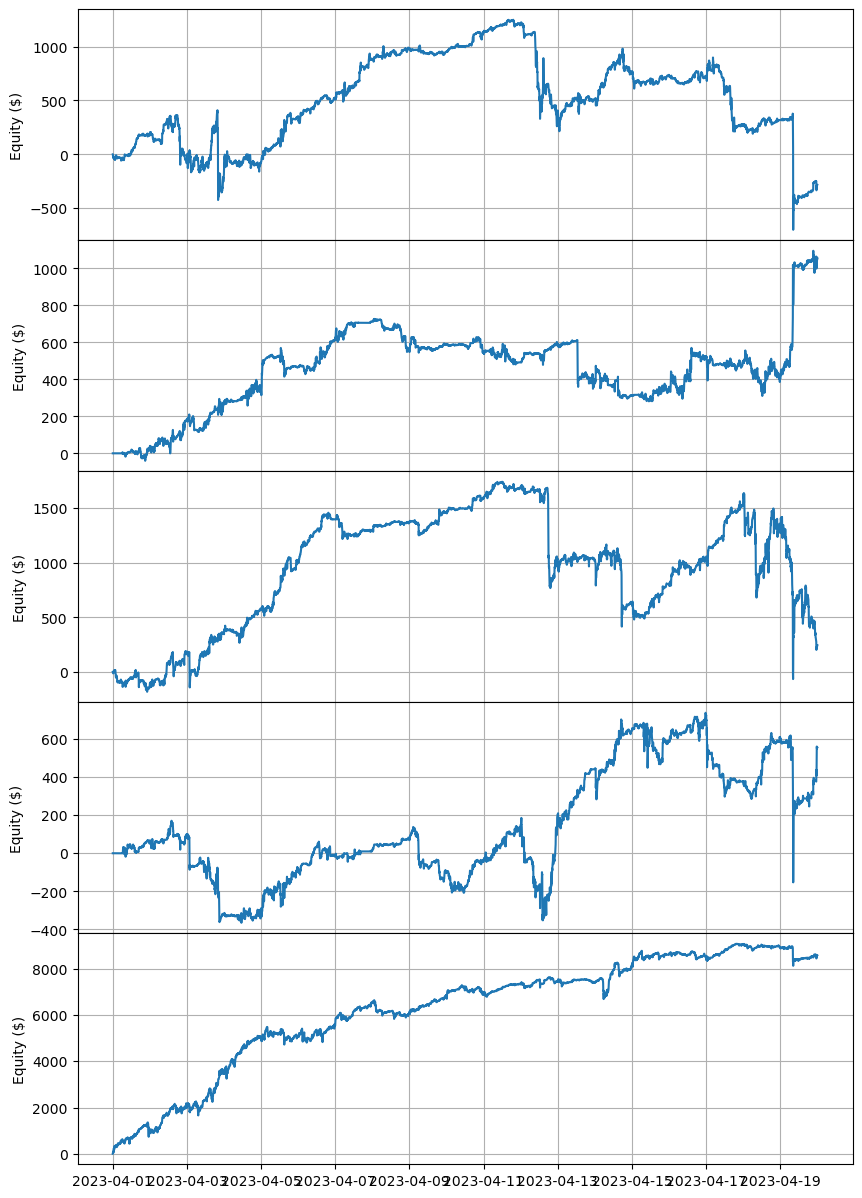

In [5]:
from matplotlib import pyplot as plt

fig, axs = plt.subplots(5, 1, sharex=True)
fig.subplots_adjust(hspace=0)
fig.set_size_inches(10, 15)

axs[0].plot(list(equity_values.values())[2])
axs[0].grid()
axs[0].set_ylabel('Equity ($)')

axs[1].plot(list(equity_values.values())[6])
axs[1].grid()
axs[1].set_ylabel('Equity ($)')

axs[2].plot(list(equity_values.values())[7])
axs[2].grid()
axs[2].set_ylabel('Equity ($)')

axs[3].plot(list(equity_values.values())[12])
axs[3].grid()
axs[3].set_ylabel('Equity ($)')

axs[4].plot(list(equity_values.values())[14])
axs[4].grid()
axs[4].set_ylabel('Equity ($)')

Text(0, 0.5, 'Cumulative Returns (%)')

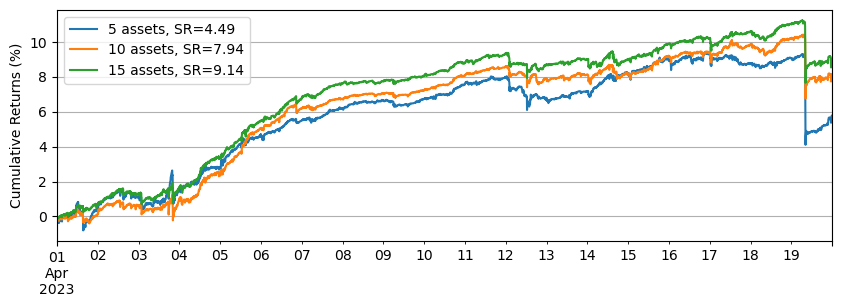

In [7]:
fig = plt.figure()
fig.set_size_inches(10, 3)

legend = []
net_equity = None
for i, equity in enumerate(list(equity_values.values())):
    asset_number = i + 1
    if net_equity is None:
        net_equity = equity.copy()
    else:
        net_equity += equity.copy()

    if asset_number % 5 == 0:
        net_equity_ = (net_equity / asset_number) / 20_000
        pnl = net_equity_.diff()
        sr = pnl.mean() / pnl.std() * np.sqrt(288 * 252)
        legend.append('{} assets, SR={:.2f}'.format(asset_number, sr))
        (net_equity_ * 100).plot()
        
plt.legend(legend)
plt.grid()
plt.ylabel('Cumulative Returns (%)')